In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from cosmic_calc import * 

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### write sf/q info and load catalog

In [4]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [301]:
diagram_type = 'NUVrK'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
    
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    sfq_nuvrk = []
    cat_output_no_nir_mass_name = graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_22.4_formass.fits'
    cat = Table.read(cat_output_no_nir_mass_name)
    for i in tqdm(range(len(cat))):
        gal = cat[i]
        if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
            rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
            nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
            if gal['Z_ML']>0 and gal['Z_ML']<1.5:
                delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
                if delta_gv_nuvrk<0:
                    sfq_nuvrk.append(1.)
                else:
                    sfq_nuvrk.append(0.)
            else:
                sfq_nuvrk.append(-99.)
        else:
            sfq_nuvrk.append(99.)
        
    sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
    if 'sfq_nuvrk_myrun' in cat.keys():
        cat.remove_column('sfq_nuvrk_myrun')
    cat.add_column(sfq_col_nuvrk)
    cat.write(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'),overwrite=True)
    

100%|██████████| 900000/900000 [05:12<00:00, 2883.00it/s]


In [16]:
cat_output_no_nir_mass_name = graham_output_dir+'cat_out_300k_nonir_il_formass.fits'
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'))
arr,ind = np.unique(cat['STRING_INPUT'],return_index=True)
cat = cat[ind]

#### completeness esitmation

In [6]:
from scipy.optimize import curve_fit
def sigmoid(x,a,b):
    return 1/(1+np.exp(-(x+b)/a+1))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

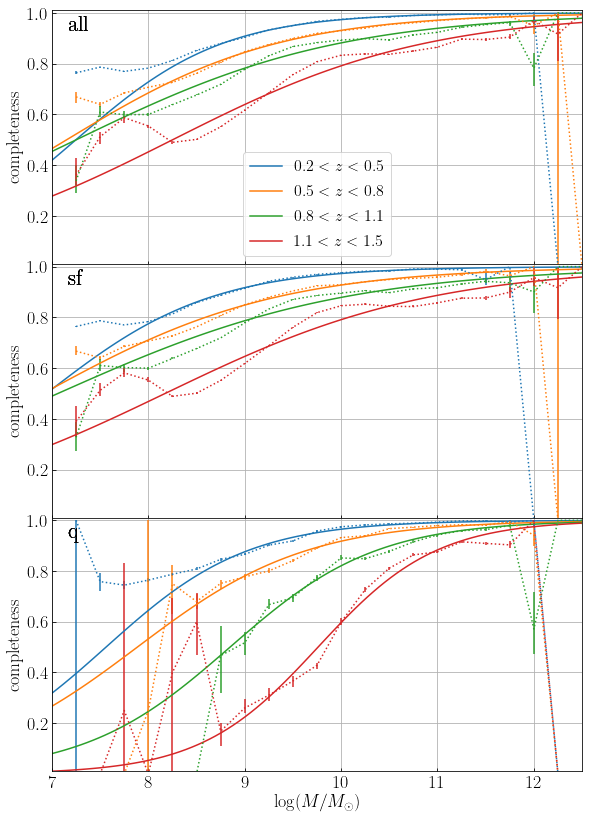

In [25]:
bin_edges = np.linspace(7, 13, num=25)
bin_centers = np.diff(bin_edges) + bin_edges[:-1]
comp_sigmoid_params = Table(names=['z','sfq','a','b'],dtype=['f8','a4','f8','f8'])
inside_j=True

zmins = [0.2,0.5,0.8,1.1]
zmaxs = [0.5,0.8,1.1,1.5]
# zmins = [0.3,0.5,0.7,0.9]
# zmaxs = [0.5,0.7,0.9,1.1]
fig, axs = plt.subplots(3, 1, figsize=(9.5,14),sharex=True, sharey=True)
for i,sfq in enumerate(['all','sf','q']):
    for k,z in enumerate(zmins):
        
        filename = 'completeness_curve_mag/curves/comp_bootstrap_nomaglimit_mass_sfq_nuvrk_myrun_'+sfq+'_'+str(zmins[k])+'_'+str(zmaxs[k])+'.txt'
        curves_mass = np.genfromtxt(filename)
        comp_all = np.median(curves_mass, axis=0)
        comp_all_l = np.percentile(curves_mass,16, axis=0)    
        comp_all_h = np.percentile(curves_mass,84, axis=0)
        if sfq == 'q':
            for j in range(len(comp_all)):
                if j<len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=0
                elif j>len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=1
        else:
            comp_all[np.isnan(comp_all)]=1
        
        # plot data
        axs[i].errorbar(bin_centers,comp_all,yerr=[comp_all-comp_all_l,comp_all_h-comp_all],fmt=colors[k],linestyle=':')
        
        # fitting (modified) sigmoid function to the curves
        popt, pcov = curve_fit(sigmoid, bin_centers[6:-5], comp_all[6:-5],maxfev = 1000)   
        comp_sigmoid_params.add_row([round(z,1),sfq,popt[0],popt[1]])
    
        # plot the sigmoid fit
        x_plot = np.linspace(7,13,100)
        y_plot = sigmoid(x_plot,popt[0],popt[1])
        axs[i].plot(x_plot,y_plot,label=r'$'+str(zmins[k])+'<z<'+str(zmaxs[k])+'$')
    
        axs[i].annotate(sfq,xy=([0.03,0.92]),xycoords='axes fraction',fontsize=22)
        axs[i].set_ylabel('completeness',fontsize=18)
        axs[0].legend(fontsize=16)
        axs[i].set_xlim([7,12.5])
    axs[i].grid()
        
plt.ylim([0.01,1.01])
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

comp_sigmoid_params.write('comp_sigmoid_params.fits',overwrite=True)

#### mass vs z
use overall catalog

(6.8, 12.6)

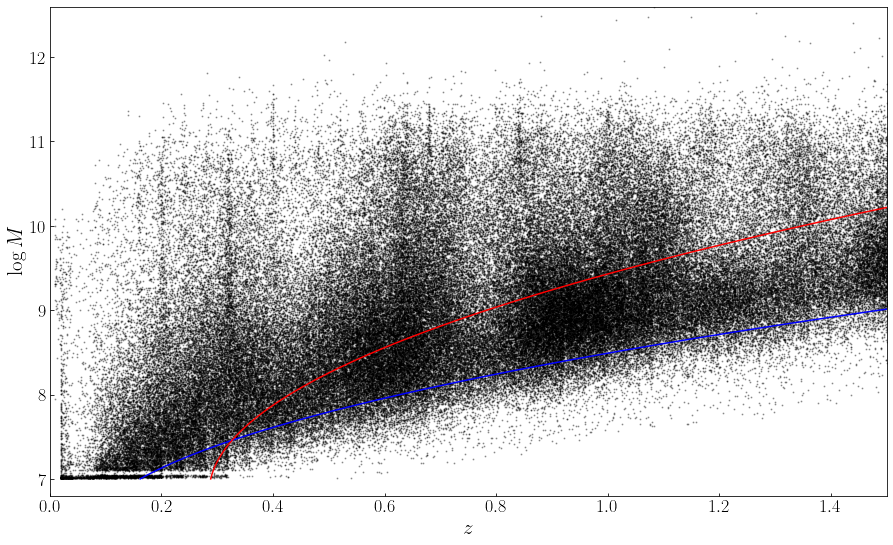

In [38]:
cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass.fits')

# z_edges = np.linspace(0,1.6,17)
# m_mins = []
# for z_min in z_edges[:-1]:
#     cat_z= cat[cat['Z_ML']>z_min]
#     cat_z= cat_z[cat_z['Z_ML']<z_min+0.1]
    
#     mass_cut20 = np.percentile(cat_z['MASS_MED_massrun'],20)
#     cat_z_lowmass = cat_z[cat_z['MASS_MED_massrun']<mass_cut20]
#     m_lims = cat_z_lowmass['MASS_MED_massrun'] + 0.4*(cat_z_lowmass['i']-26)
#     m_min =  np.percentile(m_lims,95)
#     m_mins.append(m_min)

fig, axs = plt.subplots(1, 1, figsize = (15, 9),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c='k',alpha=0.3)
# plt.plot(z_edges[:-1]+0.05,m_mins,color='r')

# plt.scatter([0.4,0.6,0.8,1.0],[8.6,9.2,9.5,9.75],s=50,color='r')
# plt.scatter([0.4,0.6,0.8,1.0],[8.2,8.5,8.8,9.0],s=50,color='orange')

# fit a 2nd order polonomial (mass as independent variable)
# p = np.polyfit(m_mins,z_edges[:-1]+0.05,deg=2)
# mass_plot = np.linspace(7,12.5,1000)
# plt.plot(p[0]*mass_plot**2 + p[1]*mass_plot + p[2], mass_plot, color='b')

# fit for sf and q galaxies (70% completeness from v9 catalog)
xs = [0.4,0.6,0.8,1.0]
ys_sf = [7.6, 8, 8.2, 8.5]
ys_q = [7.9, 8.5, 9.1, 9.4]

mass_plot = np.linspace(7,12.5,1000)
p_sf = np.polyfit(ys_sf,xs,deg=2)
p_q = np.polyfit(ys_q,xs,deg=2)
plt.plot(p_sf[0]*mass_plot**2 + p_sf[1]*mass_plot + p_sf[2], mass_plot, color='b')
plt.plot(p_q[0]*mass_plot**2 + p_q[1]*mass_plot + p_q[2], mass_plot, color='r')

plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,1.5])
plt.ylim([6.8,12.6])

#### estimate area

In [7]:
cosmos_v9 = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
inside_j=cosmos_v9['inside_j']

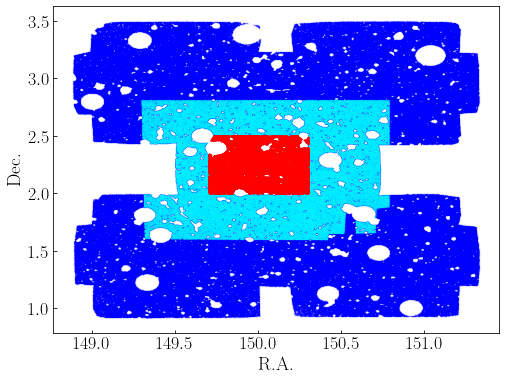

In [8]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True, sharey=True)
cat_output_full_name = output_dir+'cat_out_15band_il.fits'
cat_output = Table.read(cat_output_full_name)

plt.scatter(cosmos_v9['RA'],cosmos_v9 ['DEC'],s=0.1,alpha=0.1,c='b')
plt.scatter(cosmos_v9[inside_j]['RA'],cosmos_v9[inside_j]['DEC'],s=0.1,alpha=0.1,c='cyan')
plt.scatter(cat_output['RA'],cat_output['DEC'],s=1,color='r')

plt.xlabel('R.A.',fontsize=19)
plt.ylabel('Dec.',fontsize=19)
plt.savefig('/Users/lejay/Desktop/smf_paper/sky_plot.png')


In [40]:
# based on ra/dec limit
d_ra = 151.0 - 148.3
dec_1 = 0.6
dec_2 = 4.0
area = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees

# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
# cat_random = cat_random[cat_random['RA'] > 149.7]
# cat_random = cat_random[cat_random['RA'] < 150.3]
# cat_random = cat_random[cat_random['DEC'] > 2.0]
# cat_random = cat_random[cat_random['DEC'] < 2.5]
cat_random = cat_random[cat_random['RA'] > 148.3]
cat_random = cat_random[cat_random['RA'] < 151.9]
cat_random = cat_random[cat_random['DEC'] > 0.6]
cat_random = cat_random[cat_random['DEC'] < 4.0]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area = area * len(cat_random_nomask)/len(cat_random)
print(area)

# volume
total_soid_angle = 360**2/np.pi

3.3048695671346136


#### Thibaud's Stellar Mass Functions

In [48]:
# 0.2 - 0.5 
data_q1 = np.array([8.9170, -2.7438,
9.0377, -2.8086,
9.1584, -2.9081,
9.2867, -2.9816,
9.4049, -3.0508,
9.5256, -3.1027,
9.6513, -3.0984,
9.7695, -3.0854,
9.8927, -3.0422,
10.018, -2.9773,
10.139, -2.9341,
10.262, -2.9168,
10.383, -2.8692,
10.506, -2.8692,
10.627, -2.8605,
10.755, -2.9038,
10.873, -2.9946,
10.994, -3.0897,
11.120, -3.2800,
11.243, -3.4703,
11.364, -3.7946,
11.487, -4.1665,
11.605, -4.5081,
11.731, -4.9276,
11.839, -5.5330])
data_q1 = data_q1.reshape(len(data_q1)//2,2)

# 0.5 - 0.8
data_q2 = np.array([9.6745, -3.3924,
9.7626, -3.2670,
9.8557, -3.2368,
9.9463, -3.2022,
10.049, -3.1589,
10.135, -3.1157,
10.231, -3.0984,
10.319, -3.0595,
10.412, -3.0292,
10.508, -3.0032,
10.601, -3.0335,
10.701, -3.0119,
10.789, -3.0595,
10.883, -3.1027,
10.978, -3.1762,
11.066, -3.2800,
11.167, -3.4357,
11.268, -3.5870,
11.348, -3.7859,
11.439, -4.0584,
11.537, -4.3568,
11.615, -4.5989,
11.708, -5.2995,
11.801, -5.5114,
11.924, -6.0130])
data_q2 = data_q2.reshape(len(data_q2)//2,2)

# 0.8 - 1.1
data_q3 = np.array([10.116, -3.2757,
10.290, -3.2151,
10.476, -3.0465,
10.657, -2.9730,
10.836, -3.0292,
11.020, -3.2022,
11.199, -3.5049,
11.383, -3.9892,
11.567, -4.6551,
11.746, -5.4897])
data_q3 = data_q3.reshape(len(data_q3)//2,2)

# 1.1 - 1.5
data_q4 = np.array([10.354, -4.0195,
10.437, -3.8681,
10.545, -3.7600,
10.654, -3.7514,
10.759, -3.5654,
10.857, -3.5178,
10.956, -3.4962,
11.051, -3.5697,
11.172, -3.6908,
11.263, -3.8638,
11.371, -4.2141,
11.474, -4.5600,
11.577, -5.0486,
11.673, -5.4465,
11.781, -5.9438,
11.884, -6.0951])
data_q4 = data_q4.reshape(len(data_q4)//2,2)

data_q_list = [data_q1,data_q2,data_q3,data_q4]

In [47]:
# 0.2 - 0.5 
data_sf1 = np.array([8.7888, -1.9092,
8.9070, -1.9697,
9.0427, -1.9784,
9.1584, -2.0389,
9.2816, -2.0865,
9.3973, -2.1514,
9.5331, -2.2162,
9.6513, -2.2854,
9.7921, -2.3286,
9.9053, -2.3373,
10.023, -2.4108,
10.154, -2.4368,
10.275, -2.5059,
10.406, -2.5535,
10.519, -2.6443,
10.645, -2.7395,
10.758, -2.9038,
10.891, -3.0465,
11.009, -3.3189,
11.132, -3.5611,
11.261, -3.9373,
11.386, -4.3438,
11.502, -4.9405,
11.635, -5.9568])
data_sf1 = data_sf1.reshape(len(data_sf1)//2,2)
                   
# 0.5 - 0.8
data_sf2 = np.array([9.4857, -2.2292,
9.6871, -2.2811,
9.7978, -2.3373,
9.8935, -2.3978,
10.017, -2.4497,
10.128, -2.4973,
10.226, -2.5189,
10.341, -2.5578,
10.440, -2.5838,
10.550, -2.6530,
10.661, -2.7568,
10.762, -2.8519,
10.878, -2.9686,
10.983, -3.1589,
11.079, -3.3924,
11.197, -3.6822,
11.293, -4.0195,
11.421, -4.3395,
11.524, -4.8368,
11.628, -5.3946,
11.711, -6.0346,
11.985, -6.2249])
data_sf2 = data_sf2.reshape(len(data_sf2)//2,2)


# 0.8 - 1.1
data_sf3 = np.array([9.9622, -2.4843,
10.038, -2.4541,
10.108, -2.5103,
10.194, -2.5319,
10.262, -2.5665,
10.325, -2.5838,
10.406, -2.6141,
10.489, -2.6400,
10.549, -2.6573,
10.625, -2.7135,
10.713, -2.7697,
10.786, -2.8389,
10.864, -2.9168,
10.945, -3.0162,
11.005, -3.1416,
11.081, -3.2843,
11.146, -3.4616,
11.222, -3.7038,
11.297, -3.9416,
11.380, -4.2011,
11.456, -4.5903,
11.597, -5.3470,
11.748, -6.1038])
data_sf3 = data_sf3.reshape(len(data_sf3)//2,2)

# 1.1 - 1.5
data_sf4 = np.array([10.284, -2.7827,
10.321, -2.7611,
10.359, -2.7308,
10.399, -2.7178,
10.442, -2.7827,
10.497, -2.7957,
10.568, -2.8476,
10.648, -2.8822,
10.724, -2.9211,
10.789, -2.9643,
10.870, -3.0378,
10.945, -3.1200,
11.013, -3.2151,
11.081, -3.3319,
11.159, -3.4876,
11.230, -3.6562,
11.313, -3.8941,
11.383, -4.2097,
11.451, -4.4995,
11.527, -4.8368,
11.592, -5.0400,
11.663, -5.5459,
11.731, -6.2076])
data_sf4 = data_sf4.reshape(len(data_sf4)//2,2)

data_sf_list = [data_sf1,data_sf2,data_sf3,data_sf4]

#### comoving cosmic volume
$H_0=69.6$ km/s/Mpc, $\Omega_M=0.286$

In [44]:
V2 = 2.336 # cosmic volume at z=0.2, Gpc^3
V5 = 29.127
V8 = 94.303
V11 = 194.160
V15 = 365.540

In [45]:
Va = (V5-V2)*area/total_soid_angle*10**9 # in Mpc^3
Vb = (V8-V5)*area/total_soid_angle*10**9 # in Mpc^3
Vc = (V11-V8)*area/total_soid_angle*10**9 # in Mpc^3
Vd = (V15-V11)*area/total_soid_angle*10**9 # in Mpc^3
cosmic_volumes = [Va,Vb,Vc,Vd]

In [43]:
def poisson_interval(k, a=0.3174): 
    lows = chi2.ppf(a/2, 2*k)/2
    highs = chi2.ppf(1-a/2, 2*k+2)/2 
    
    lows=np.array(lows)
    highs=np.array(highs)
    
    lows[np.isnan(lows)]=0
    return lows, highs

In [51]:
cat_comp = Table.read('comp_sigmoid_params.fits')
cat_comp

z,sfq,a,b
float64,bytes4,float64,float64
0.2,all,0.7633562294101229,-6.485448576787617
0.5,all,1.0927144718257695,-6.059699550854962
0.8,all,1.3672830840481707,-5.884948033728201
1.1,all,1.3108789020131946,-6.9408471040500475
0.2,sf,0.8557063658979723,-6.087248577736896
0.5,sf,1.2152959678316142,-5.69194426030214
0.8,sf,1.484686152475782,-5.577764233450082
1.1,sf,1.3728981071434965,-6.801454897062221
0.2,q,0.7365629834861314,-6.823989404098361


In [ ]:
cat = Table.read(graham_output_dir+'COSMOS_deep_cat_out_nonir_il_22.4_formass_sfq_added.fits')
# cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass_sfq_added.fits')
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
norms = [1,1,1,1]
num_bins = 50

cat_comp = Table.read('comp_sigmoid_params.fits')
for i in range(len(z_mins)):
    print(z_mins[i])
    row = i//2
    col = i%2
    cat_z = cat[cat['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    cat_z['MASS_MED_massrun'] = cat_z['MASS_MED_massrun'] - mass_shift[i]
            
    # 1/vmax normalization
    bins = np.linspace(8,12.2,num_bins)
    bin_size = bins[1]-bins[0]
    inv_volumes = [] # sum of inverse of volumes
    for bin_num in tqdm(range(num_bins-1)):
        inv_volume = 0
        cat_massbin = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>bins[bin_num], cat_z['MASS_MED_massrun']<bins[bin_num+1])]
        zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
        if zmax_in_bin > z_maxs[i]:
            inv_volume = len(cat_massbin) / (total_volume*area/total_soid_angle)
        else:
            max_gals_in_bin = 500
            if len(cat_massbin)> max_gals_in_bin:
                select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                cat_select = cat_massbin[select_ids]
            else:
                cat_select = cat_massbin
                    
        for gal in cat_select:
            zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
            total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
            inv_volume += 1 / (total_volume*area/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
        inv_volumes.append(inv_volume)            
        
    # histograms (normalization and correction)
    sampling_factor = 1. #300000/1357601
    comp_param = cat_comp[i]
    completeness = sigmoid(bins[:-1]+bin_size/2,comp_param[2],comp_param[3])
    weights = 1/bin_size/sampling_factor/completeness
    axs[row][col].plot(bins[1:],np.array(inv_volumes)*weights,ls='steps',color='k')
        
    # mass errorbars (randomly disturb the masses)
#     mass_list = cat_z['MASS_MED_massrun']
#     n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
#     hist_stack = []
#     for k in range(20):
#         mass_list_rand = mass_list + np.random.normal(0.2,size=len(mass_list))
#         hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
#         hist_stack.append(hist)

#     mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
#     mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
    
#     # poisson errorbars
#     poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
#     poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
        
#     # total errorbars
#     errbar_minus = mass_errbar_minus + poisson_errbar_minus
#     errbar_plus = mass_errbar_plus + poisson_errbar_plus
#     axs[row][col].errorbar(bins[:-1]+np.diff(bins)/2, np.array(inv_volumes)*weights, yerr=np.array([errbar_minus*np.array(inv_volumes)/n,errbar_plus*np.array(inv_volumes)/n]) , color=color,linewidth=1,capsize=2)
        
    # save to disc
    # smf_total = np.stack([np.array(inv_volumes)*weights, errbar_minus*np.array(inv_volumes)/n, errbar_plus*np.array(inv_volumes)/n])
    # np.save( 'smf_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
    
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')

0.2


100%|██████████| 49/49 [00:02<00:00, 18.63it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


[15.789 15.352 14.96  14.61  14.298 14.018 13.768 13.545 13.346 13.167
 13.008 12.866 12.738 12.624 12.523 12.432 12.35  12.278 12.213 12.155
 12.103 12.057 12.015 11.978 11.945 11.916 11.889 11.866 11.844 11.826
 11.809 11.794 11.78  11.768 11.757 11.748 11.739 11.731 11.724 11.718
 11.713 11.708 11.704 11.7   11.696 11.693 11.69  11.688 11.685]
[3.951e-03 3.804e-03 3.589e-03 3.475e-03 3.145e-03 3.006e-03 2.704e-03
 2.474e-03 2.277e-03 2.025e-03 1.836e-03 1.605e-03 1.390e-03 1.244e-03
 1.125e-03 1.031e-03 9.108e-04 8.777e-04 7.934e-04 7.263e-04 6.262e-04
 5.684e-04 5.511e-04 4.664e-04 4.351e-04 4.519e-04 4.454e-04 3.872e-04
 3.722e-04 3.331e-04 3.014e-04 3.033e-04 2.469e-04 1.808e-04 1.323e-04
 1.165e-04 8.386e-05 5.078e-05 4.705e-05 3.168e-05 2.097e-05 1.304e-05
 8.386e-06 4.659e-06 3.727e-06 1.864e-06 9.318e-07 0.000e+00 0.000e+00]
[6.238e-02 5.839e-02 5.370e-02 5.077e-02 4.496e-02 4.214e-02 3.724e-02
 3.351e-02 3.039e-02 2.666e-02 2.388e-02 2.064e-02 1.770e-02 1.571e-02
 1.409e-02 

 37%|███▋      | 18/49 [00:32<00:56,  1.81s/it]

0.2


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 49/49 [00:22<00:00,  2.13it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separa

0.5


100%|██████████| 49/49 [00:34<00:00,  1.44it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:25<00:00,  1.94it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


0.8


100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:17<00:00,  2.75it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


1.1


100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:16<00:00,  2.98it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


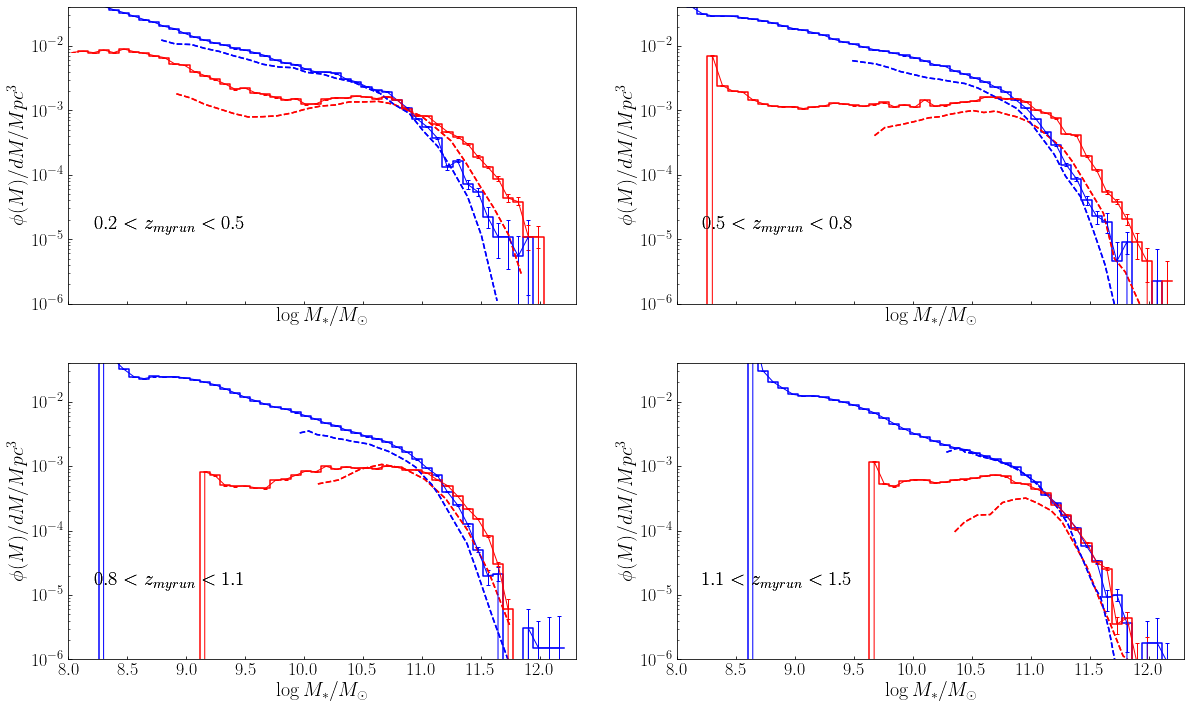

In [49]:
cat = Table.read(graham_output_dir+'COSMOS_deep_cat_out_nonir_il_22.4_formass_sfq_added.fits')
# cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass_sfq_added.fits')
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
norms = [1,1,1,1]
num_bins = 50

cat_comp = Table.read('comp_sigmoid_params.fits')
for i in range(len(z_mins)):
    print(z_mins[i])
    row = i//2
    col = i%2
    cat_z = cat[cat['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    cat_z['MASS_MED_massrun'] = cat_z['MASS_MED_massrun'] - mass_shift[i]
    for k, sfq_type in enumerate(['sf','q']):
        if sfq_type == 'sf':
            cat_z_sfqtype = cat_z[cat_z['sfq_nuvrk_myrun']>0.5]
            color='b'
        else:
            cat_z_sfqtype= cat_z[cat_z['sfq_nuvrk_myrun']<0.5]
            color='r'
            
        # 1/vmax normalization
        bins = np.linspace(8,12.2,num_bins)
        bin_size = bins[1]-bins[0]
        inv_volumes = [] # sum of inverse of volumes
        for bin_num in tqdm(range(num_bins-1)):
            inv_volume = 0
            cat_massbin = cat_z_sfqtype[np.logical_and(cat_z_sfqtype['MASS_MED_massrun']>bins[bin_num], cat_z_sfqtype['MASS_MED_massrun']<bins[bin_num+1])]
            if cosmic_calc(bins[bin_num]) < z_maxs[i]:
                inv_volume = len(cat_massbin) / (total_volume*area/total_soid_angle)
            else:
                max_gals_in_bin = 500
                if len(cat_massbin)> max_gals_in_bin:
                    select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                    cat_select = cat_massbin[select_ids]
                else:
                    cat_select = cat_massbin
                    
                for gal in cat_select:
                    if sfq_type == 'sf':
                        zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
                    else:
                        zmax = p_q[0]*gal['MASS_MED_massrun']**2 + p_q[1]*gal['MASS_MED_massrun'] + p_q[2]
                    total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                    inv_volume += 1 / (total_volume*area/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
            inv_volumes.append(inv_volume)            
        
        # histograms (normalization and correction)
        sampling_factor = 1. #300000/1357601
        comp_param = cat_comp[(k+1)*4+i]
        completeness = sigmoid(bins[:-1]+bin_size/2,comp_param[2],comp_param[3])
        weights = 1/bin_size/sampling_factor/completeness
        axs[row][col].plot(bins[1:],np.array(inv_volumes)*weights,ls='steps',color=color)
        
        # mass errorbars (randomly disturb the masses)
        mass_list = cat_z_sfqtype['MASS_MED_massrun']
        n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
        hist_stack = []
        for k in range(20):
            mass_list_rand = mass_list + np.random.normal(0.2,size=len(mass_list))
            hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
            hist_stack.append(hist)

        mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
        mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
    
        # poisson errorbars
        poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
        poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
        
        # total errorbars
        errbar_minus = mass_errbar_minus + poisson_errbar_minus
        errbar_plus = mass_errbar_plus + poisson_errbar_plus
        axs[row][col].errorbar(bins[:-1]+np.diff(bins)/2, np.array(inv_volumes)*weights, yerr=np.array([errbar_minus*np.array(inv_volumes)/n,errbar_plus*np.array(inv_volumes)/n]) , color=color,linewidth=1,capsize=2)
        
        # save to disc
        smf_total = np.stack([np.array(inv_volumes)*weights, errbar_minus*np.array(inv_volumes)/n, errbar_plus*np.array(inv_volumes)/n])
        np.save( 'smf_'+sfq_type+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
        
        # reference from Moutard et al. 2016
        axs[row][col].plot(data_q_list[i][:,0],10**data_q_list[i][:,1]*norms[i],'--r')
        axs[row][col].plot(data_sf_list[i][:,0],10**data_sf_list[i][:,1]*norms[i],'--b')
    
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        axs[row][col].set_ylim([1e-6,4e-2])
        axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')
# plt.savefig('/Users/lejay/Desktop/smf_paper/smf.png')
# plt.show()

#### schecter function fit

In [289]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(m,phi,m_s,alpha_s):
    m=10**(m-7)
    return phi*(m/m_s)**(alpha_s+1)*np.exp(-((m/m_s)**2))

def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 200
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel  = kernel / sum(kernel)
    
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]
            
    return con_values

# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end):
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

#### MCMC fit

In [292]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

def log_likelihood_convolve(theta, x, y, yerr, sigma):
    phi,m_s,alpha_s = theta
    model = con_schechter(x, phi, m_s, alpha_s,sigma)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_likelihood(theta, x, y, yerr):
    phi,m_s,alpha_s = theta
    model = schechter(x, phi, m_s, alpha_s)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    phi,m_s,alpha_s = theta
    if 0 < phi < np.inf and 0.0 < m_s < 2e5 and -10.0 < alpha_s < 10.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [335]:
# data
smf = np.load('smf_sf_0.2_0.5.npy')
bins = np.linspace(8,12.2,num_bins)
x = bins[:-1]+np.diff(bins)/2
y = smf[0]
yerr = (smf[1]+smf[2])/2
yerr[np.isnan(yerr)]=1e-8

In [325]:


# MCMC fit
nll = lambda *args: -log_likelihood_convolve(*args) # Negative Log-Likelihood
initial = np.array([2e-4,2.2e+04,-1.75])
soln = minimize(nll, initial, args=(x, y, yerr,0.25))
phi_ml,m_s_ml,alpha_s_ml = soln.x  # initial guess?
print('initial guess:',soln.x) 
pos = soln.x + 0.2*np.array([1e-4,1e+04,1])*np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 50000, progress=True)
params = np.mean(sampler.get_chain(discard=200, thin=15, flat=True),axis=0)
print('Best MCMC:',params)

# scipy curve_fit
popt,pcov,chi2_ = fit_schechter(bins[:-1]+np.diff(bins)/2, y, yerr,start=5,end=-9)
print('Best Curve fit:',popt)

  0%|          | 0/50000 [00:00<?, ?it/s]

initial guess: [ 7.830e-04  1.248e+04 -1.616e+00]


100%|██████████| 50000/50000 [05:37<00:00, 148.05it/s]


Best MCMC: [ 1.296e-03  1.203e+04 -1.506e+00]
Best Curve fit: [ 1.299e-03  1.347e+04 -1.514e+00]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
# shecter fit (convolved) for all curves:

for z in []:
    for sfq_type in ['sf','q']:
        x = 
        y = 
        yerr = 
        
        

Text(0.05, 0.24, '$0.2<z_{myrun}<0.5$')

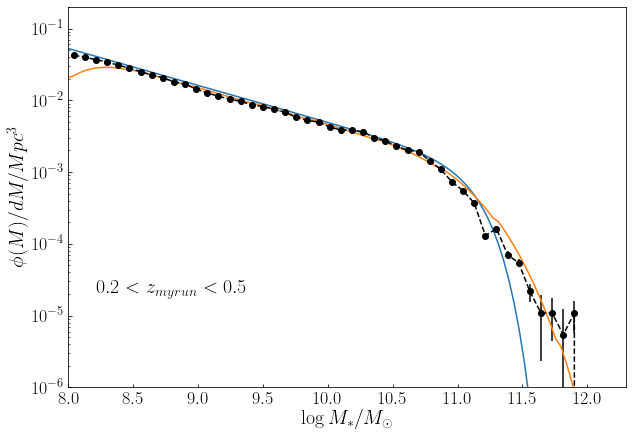

In [346]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)

plt.errorbar(x,y,yerr,fmt='ok--')
x_plot = np.linspace(8,12,100)
plt.plot(x_plot,schechter(x_plot,popt[0],popt[1],popt[2]))
plt.plot(x_plot,con_schechter(x_plot,params[0],params[1],params[2],0.24))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
plt.yscale('log')
plt.xlim([8,12.3])
plt.ylim([1e-6,2e-1])
plt.annotate('$0.2<z_{myrun}<0.5$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')


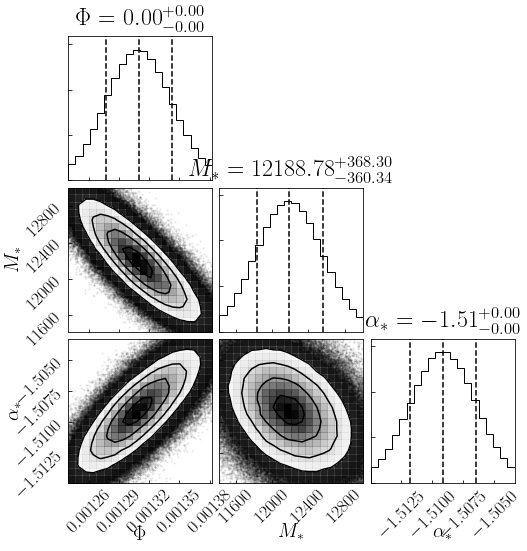

In [297]:
import corner
from matplotlib import rcParams
rcParams["font.size"] = 20
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

labels = [r"$\Phi$", r"$M_*$", r"$\alpha_*$"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[phi_ml, m_s_ml, alpha_s_ml],show_titles=True,quantiles=[.16,.50,.84],range=[0.97,0.97,0.97] 
);

#### MCMC with Thibaud's data

In [81]:
# maximum likelihood

import emcee
from scipy.optimize import minimize

# data
x = data_sf1[:,0]
y = 10**data_sf1[:,1]
yerr = 10**data_sf1[:,1]/10

nll = lambda *args: -log_likelihood(*args) # Negative Log-Likelihood
initial = np.array([2e-4,1e+04,-1.5]) + 0.01*np.array([1e-4,5e+03,0.5])*np.random.randn( 3)
soln = minimize(nll, initial, args=(x, y, yerr))
phi_ml,m_s_ml,alpha_s_ml = soln.x  # initial guess?
print(soln.x) 

pos = np.array([2e-4,1e+04,-1.5]) + 0.1*np.array([1e-4,1e+04,1])*np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 10000, progress=True)
params = np.mean(sampler.get_chain(discard=200, thin=15, flat=True),axis=0)
print(params)
print(popt)

  0%|          | 10/10000 [00:00<01:42, 97.38it/s]

[ 5.988e-04  1.667e+04 -1.583e+00]


100%|██████████| 10000/10000 [01:08<00:00, 144.98it/s]

[ 6.062e-04  1.660e+04 -1.581e+00]
[ 3.049e-04  1.017e+04 -1.493e+00]


#### cosmic variance

#### COSMOS DEEP ELAIS

1357601
1090962
1155513


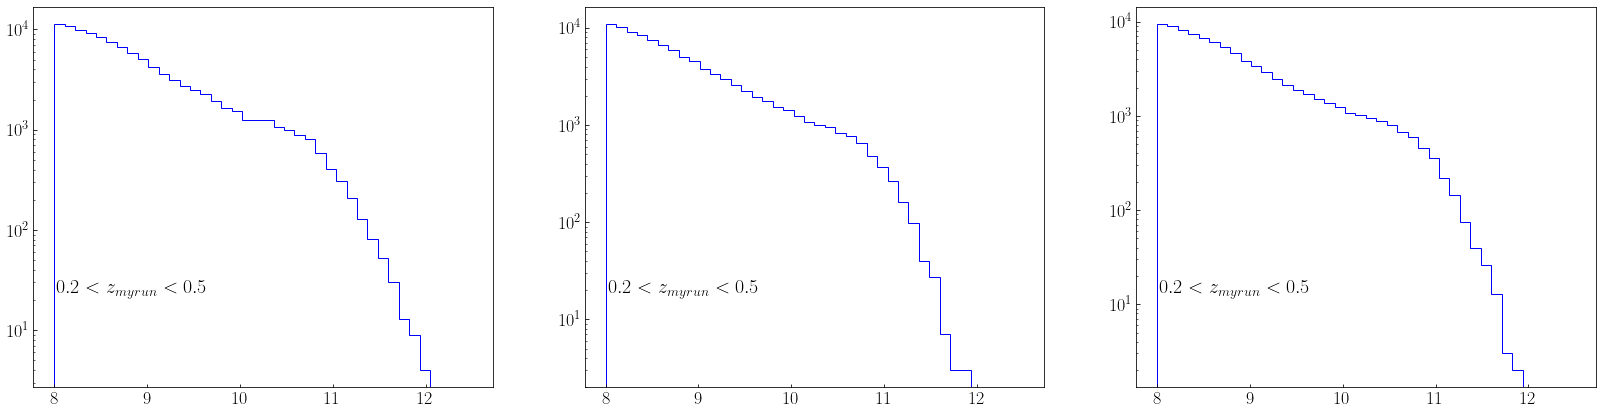

In [127]:
fig, axs = plt.subplots(1, 3, figsize = (28, 7),sharex=True)

for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    print(len(cat))
    cat_z = cat[cat['Z_ML']>0.2]
    cat_z = cat_z[cat_z['Z_ML']<0.5]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    
    axs[i].hist(cat_z['MASS_MED_massrun'],range=(8,12.5),bins=40,histtype='step',color='b')
    axs[i].set_yscale('log')
    axs[i].annotate('$0.2<z_{myrun}<0.5$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')

In [174]:
def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [179]:
x = np.linspace(8,12.2,43)
dx = (12.2-8)/43
y=schechter(x,3.183e-4/1.1,8.765e+03,-1.489e+00)

kernel = []
for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
    kernel.append(gaussian(i*dx,0,0.25))

kernel  = kernel / sum(kernel)

200 200 71 200
[3.316e-03 3.501e-03 3.679e-03 3.849e-03 4.008e-03 4.155e-03 4.290e-03
 4.412e-03 4.519e-03 4.611e-03 4.689e-03 4.751e-03 4.798e-03 4.831e-03
 4.850e-03 4.855e-03 4.848e-03 4.830e-03 4.800e-03 4.762e-03 4.714e-03
 4.659e-03 4.598e-03 4.530e-03 4.459e-03 4.383e-03 4.304e-03 4.224e-03
 4.141e-03 4.057e-03 3.973e-03 3.889e-03 3.804e-03 3.721e-03 3.638e-03
 3.556e-03 3.472e-03 3.391e-03 3.311e-03 3.233e-03 3.157e-03 3.083e-03
 3.011e-03 2.940e-03 2.871e-03 2.803e-03 2.738e-03 2.673e-03 2.610e-03
 2.549e-03 2.489e-03 2.431e-03 2.374e-03 2.318e-03 2.263e-03 2.210e-03
 2.158e-03 2.107e-03 2.058e-03 2.009e-03 1.962e-03 1.916e-03 1.871e-03
 1.826e-03 1.783e-03 1.741e-03 1.700e-03 1.660e-03 1.621e-03 1.583e-03
 1.545e-03 1.509e-03 1.473e-03 1.438e-03 1.404e-03 1.371e-03 1.338e-03
 1.306e-03 1.275e-03 1.245e-03 1.215e-03 1.186e-03 1.158e-03 1.130e-03
 1.103e-03 1.076e-03 1.050e-03 1.024e-03 9.994e-04 9.750e-04 9.511e-04
 9.276e-04 9.047e-04 8.822e-04 8.601e-04 8.385e-04 8.172e-04 7

Text(0, 0.5, '$\\phi(M)/dM/Mpc^3$')

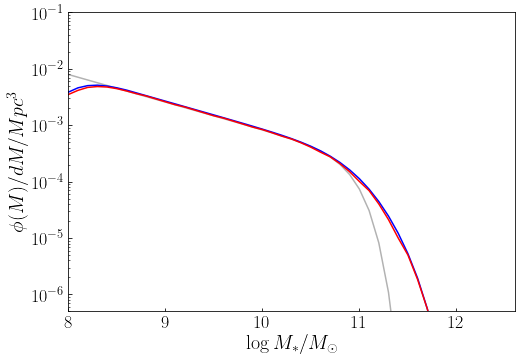

In [275]:
fig, axs = plt.subplots(1, 1, figsize = (8, 5.5),sharex=True)
plt.plot(x,y,color = 'k',alpha=0.3)
plt.plot(x,np.convolve(y,kernel,mode='same'),color='b')
plt.plot(x,con_schechter(x,3.183e-4/1.1,8.765e+03,-1.489e+00,0.25),color='r')

plt.yscale('log')
plt.xlim([8,12.6])
plt.ylim([5e-7,1e-1])
plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)

In [234]:
print(y)

[7.952e-003 7.105e-003 6.348e-003 5.672e-003 5.068e-003 4.528e-003
 4.046e-003 3.615e-003 3.230e-003 2.886e-003 2.579e-003 2.304e-003
 2.058e-003 1.839e-003 1.642e-003 1.467e-003 1.310e-003 1.169e-003
 1.042e-003 9.285e-004 8.257e-004 7.321e-004 6.463e-004 5.666e-004
 4.911e-004 4.182e-004 3.463e-004 2.743e-004 2.024e-004 1.336e-004
 7.382e-005 3.080e-005 8.235e-006 1.087e-006 4.689e-008 3.435e-010
 1.516e-013 7.788e-019 3.445e-027 2.115e-040 2.596e-061 2.001e-094
 7.067e-147]


In [249]:
x

array([ 8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,
        9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1,
       10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2,
       11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2])